## Initialization

In [4]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Constants

In [1]:
PROJECT_ROOT = 'absolute-path-of-project-root'
TRAIN_MBTR_DIR = PROJECT_ROOT + "/data/processed/training_set/features"
TEST_MBTR_DIR = PROJECT_ROOT + "/data/processed/test_set/features"
TRAIN_SASA_DIR = PROJECT_ROOT + "/data/processed/training_set/label"
TEST_SASA_DIR = PROJECT_ROOT + "/data/processed/test_set/label"
MODELS_DIR = PROJECT_ROOT + "/models"
PLOTS_DIR = PROJECT_ROOT + "/plots"
WINDOW_SIZE = 5
SAVE_MODELS = False
RANDOM_STATE = 123

## Imports

In [3]:
import numpy as np
import pandas as pd
import os
from joblib import dump, load
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import copy
import keras
from numpy.lib.stride_tricks import sliding_window_view
import random
from sklearn.model_selection import KFold
import pickle
import re
import matplotlib.pyplot as plt

# models
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## Helper Functions

In [4]:
def evaluate_results(y, y_hat, return_values = False, show_outputs = True):
  if len(y.shape) > 2:
    y = y.reshape((y.shape[0], -1))
    y_hat = y_hat.reshape((y_hat.shape[0], -1))
  mae = mean_absolute_error(y, y_hat)
  mse = mean_squared_error(y, y_hat)
  rmse = mean_squared_error(y, y_hat, squared=False)
  if show_outputs:
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
  if return_values:
    return mae, mse, rmse

In [5]:
def load_model(model_name, num_feature, directory):
    """
    Loads the sepcified model and returns the object representing that model.

    This function is a utility function that loads any of the models used in
    this project. The function reads the model from the specified directory
    through methods applicable to the type of model.

    Parameters
    ----------
    model_name : str
        ``transfomer`` or``ensemble_model``, for simulation part or
        ``sasa_model`` for SASA calculation
    num_feature : int
        Number of features in the training data
    directory : str
        absolute or relative directory for saving the models

    Returns
    -------
    object
        The object of the corresponding model's class
    """
    if model_name == 'transformer' or model_name == 'sasa_model':
        model = keras.models.load_model(directory)
        return model
    elif model_name == 'ensemble':
        model = ensemble_model(num_feature)
        model.load_model(directory)
        return model

In [6]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

In [7]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_pc(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
    pred_sasa = pred_sasa.squeeze()
    y_pred.append(pred_sasa)
    y_true.append(y_test[(i+1) * timestep - 1])

  return mean_absolute_error(y_true, y_pred)

In [8]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def calc_error_mbtr(mbtr_model, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)

  error = 0
  sim_steps = timestep - window_size - 1
  y_pred = []
  y_true = []

  for i in range(12):
    pointer = (i * timestep)
    data = x_test[pointer : pointer + WINDOW_SIZE]
    for j in (range(sim_steps)):
      next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
      data = np.concatenate((data, next_mbtr), axis = 0)
    y_pred.append(data[-1])
    y_true.append(x_test[(i+1) * timestep - 1])

    # error = error + np.sum(np.abs(data[-1] - x_test[(i+1) * timestep - 1]))

  return mean_absolute_error(y_true, y_pred), mean_squared_error(y_true, y_pred, squared=False)

## Load Data

In [9]:
def mbtr_ds_generator(directory):
  """
  Creates a dataset of the MBTR vectors.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. All the
  vectors are gathered in a dataset along with the duration of the
  simulations for the designs.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets

  Returns
  -------
  x : array of floats; shape (number of designs * duration, num_feature)
      The vector array of all the MBTRs in a sequence stacked row-wise
  timestep_size : list of int
      duration of each design for the MBTR files in the directory
  """
  ptr = 0
  timestep_size = []
  if directory[-1] != '/':
    directory = directory + '/'
  for mbtr_file in sorted(os.listdir(directory)):
    x_mbtr = pd.read_csv(directory + str(mbtr_file))
    timestep_size.append(x_mbtr.shape[0])
    if ptr == 0:
      x = np.array(x_mbtr.values.tolist())
      ptr = 1
    else:
      x = np.concatenate((x, np.array(x_mbtr.values.tolist())), axis = 0)
    # print("MBTR: ", mbtr_file, "Shape:", x.shape)

  # print("MBTR Shape:", x.shape)
  # print("timesteps: ", len(timestep_size))
  return x, timestep_size

def sasa_ds_generator(directory):
  """
  Creates a dataset of SASA values.

  This function reads all CSV data files containing the SASA values
  corresponding to different design configurations at different states.
  All the values are gathered in a dataset.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the SASA CSV datasets

  Returns
  -------
  array of floats; shape (number of designs * duration,)
      The array of all the SASA values in a sequence stacked row-wise
  """
  ptr = 0
  if directory[-1] != '/':
    directory = directory + '/'
  for sasa_file in sorted(os.listdir(directory)):
    # print("SASA: ", sasa_file)
    x_sasa = pd.read_csv(directory + str(sasa_file), sep=';')
    if ptr == 0:
          x = np.array(x_sasa['TOTAL'])
          ptr = 1
    else:
          x = np.concatenate((x, np.array(x_sasa['TOTAL'])), axis = 0)
  # print("SASA Shape:", x.shape)
  return x

def mbtr_mbtr_ds_generator(directory, window_size, sasa_dir = None, shuffle = False):
  """
  Creates a windowed dataset of the MBTR vectors, and SASA values if specified.

  This function reads all CSV data files containing MBTR vectors
  generated from data of different design configurations. Then,
  generates a sliding window based dataset pair of MBTRs. If specified
  the SASA values are also recorded.

  Parameters
  ----------
  directory : str
      absolute or relative directory of the MBTR CSV datasets
  window_size: int
      The window size to create the data pairs
  sasa_dir : str or None; default: None
      absolute or relative directory of the SASA CSV datasets,
      if ``None`` SASA values are not considered
  shuffle : bool
      Used to decide whether or not to shuffle the data order

  Returns
  -------
  dataset_x : array of floats; shape (number of samples, window_size, num_feature)
      The vector array of all the MBTRs stacked in sliding window method
  dataset_y : array of floats; shape (number of samples, num_feature)
      The array of MBTR vectors of the next timesteps of the window
  y_sasa : arrary of floats;  shape (number of samples, 1)
      The array of all the SASA values for the next timesteps of the window
  sasa_zero : array of float; shape (number of designs, 1)
      The array of initial SASA values (1st timestep) for each design configuration
  """
  dataset_x = []
  dataset_y = []
  y_sasa = []
  sasa_zero = []
  i = 0
  j = 0
  mbtr, timestep_size = mbtr_ds_generator(directory)
  if sasa_dir is not None:
    sasa = sasa_ds_generator(sasa_dir)
    if shuffle == True:
      idx = np.arange(mbtr.shape[0])
      np.random.shuffle(idx)
      mbtr = mbtr[idx]
      sasa = sasa[idx]
    assert mbtr.shape[0] == sasa.shape[0], "MBTR and SASA have mismatching shapes"
  elif shuffle == True:
    np.random.shuffle(mbtr)

  for i in range(len(timestep_size)):
    if i == 0:
        z = 0
    else:
        z = sum(timestep_size[:i])
    for j in range(z, z + timestep_size[i] - window_size):
      dataset_x.append(mbtr[j : j + window_size])
      dataset_y.append(mbtr[j + window_size])
      if not sasa_dir is None:
        y_sasa.append(sasa[j + window_size])
    if not sasa_dir is None:
      sasa_zero.append(sasa[z])
  if not sasa_dir is None:
    return np.array(dataset_x), np.array(dataset_y), np.array(y_sasa), np.array(sasa_zero)
  return np.array(dataset_x), np.array(dataset_y)

def get_X_predicted_and_y(mbtr_model):
  X, timesteps = mbtr_ds_generator(TRAIN_MBTR_DIR)
  Y = sasa_ds_generator(TRAIN_SASA_DIR)
  X_predicted = []
  labels = []
  for i in range(len(timesteps)):
    start = sum(timesteps[:i])
    end = start + timesteps[i] - 1
    current_data = X[start:start+WINDOW_SIZE]
    current_position = start + WINDOW_SIZE
    while current_position < end:
      X_predicted.append(mbtr_model.predict(np.expand_dims(current_data, axis=0)))
      labels.append(Y[current_position])
      current_data = np.concatenate((current_data[1:], X_predicted[-1]), axis=0)
      current_position = current_position + 1
  return np.array(X_predicted), np.array(labels)

## Train models

In [10]:
x_train, y_train, y_sasa_train, sasa_zero_train = mbtr_mbtr_ds_generator(TRAIN_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TRAIN_SASA_DIR, shuffle = False)
x_test, y_test, y_sasa_test, sasa_zero_test = mbtr_mbtr_ds_generator(TEST_MBTR_DIR, window_size = WINDOW_SIZE, sasa_dir=TEST_SASA_DIR, shuffle = False)
# y_train = sasa_ds_generator(TRAIN_SASA_DIR)
# y_test = sasa_ds_generator(TEST_SASA_DIR)
x_train.shape, y_train.shape, y_sasa_train.shape, x_test.shape, y_test.shape, y_sasa_test.shape

((24225, 5, 72), (24225, 72), (24225,), (3540, 5, 72), (3540, 72), (3540,))

In [11]:
x_train.std()

2908.212768072902

In [12]:
x_train_standardized = (x_train - x_train.mean()) / x_train.std()
x_test_standardized = (x_test - x_train.mean()) / x_train.std()
x_train_standardized.shape, x_test_standardized.shape

((24225, 5, 72), (3540, 5, 72))

### MBTR Training

#### Train different machine learning models

In [ ]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

In [ ]:
models = [LinearRegression,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          ExtraTreesRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'XGB',
                'AdaBoost',
                'GBM',
                'ETR',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

In [ ]:
indices = list(range(len(x_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = ensemble_model_custome(72, models[i], models_names[i])

  print("Model Name: ", models_names[i])

  if model.model_exists():
    model.load_model()
  else:
    model.train(x_train[indices], y_train[indices])

  print("Train set: ")
  evaluate_results(model.predict(x_train), y_train)
  print("Test set: ")
  evaluate_results(model.predict(x_test), y_test)
  print("Test set error of last timestep: ", calc_error_mbtr(model))

  if not model.model_exists() and SAVE_MODELS == True:
    model.save()

  print("-----------------------------\n")

Model Name:  LR
Train set: 
MAE:  1.2396836832016385
MSE:  35.94250977717815
RMSE:  1.6010085897561694
Test set: 
MAE:  1.239397261951294
MSE:  35.92656745589741
RMSE:  1.5923886360934327
Test set error of last timestep:  (6.045276021928156, 6.936915037397946)
-----------------------------

Model Name:  XGB


100%|██████████| 72/72 [00:20<00:00,  3.57it/s]


Train set: 
MAE:  1.39679894459703
MSE:  150.051767551118
RMSE:  2.908543241836446
Test set: 
MAE:  1.6803709233060653
MSE:  61.69073953692867
RMSE:  2.751071715955757
Test set error of last timestep:  (12.213516345956931, 15.427116405461975)
-----------------------------

Model Name:  AdaBoost


100%|██████████| 72/72 [01:23<00:00,  1.17s/it]


Train set: 
MAE:  10.023224908880572
MSE:  3187.2123139743553
RMSE:  12.93473229005542
Test set: 
MAE:  8.973420406014336
MSE:  2355.527655123712
RMSE:  11.739858408849328
Test set error of last timestep:  (22.58100128461675, 32.52377086398228)
-----------------------------

Model Name:  GBM


100%|██████████| 72/72 [03:27<00:00,  2.89s/it]


Train set: 
MAE:  1.4544648587005218
MSE:  52.76027368617579
RMSE:  1.892318687982568
Test set: 
MAE:  1.8127630053420443
MSE:  73.98425674015529
RMSE:  2.7198064282508807
Test set error of last timestep:  (12.18038005145576, 15.812747506086465)
-----------------------------

Model Name:  ETR


100%|██████████| 72/72 [03:03<00:00,  2.54s/it]


Train set: 
MAE:  1.0083529095600132e-05
MSE:  8.548313208790521e-08
RMSE:  8.321033255289416e-05
Test set: 
MAE:  1.248922526960561
MSE:  38.587718855325114
RMSE:  1.7394288187141749
Test set error of last timestep:  (9.710187186809737, 12.889189054433713)
-----------------------------

Model Name:  SVR


100%|██████████| 72/72 [09:39<00:00,  8.04s/it]


Train set: 
MAE:  31.239308242171187
MSE:  234632.6080143851
RMSE:  100.70642986486466
Test set: 
MAE:  5.341017035837718
MSE:  4582.582610790553
RMSE:  11.684995812889813
Test set error of last timestep:  (32.366133558224874, 41.042355894921656)
-----------------------------

Model Name:  KNR


100%|██████████| 72/72 [00:05<00:00, 12.61it/s]


Train set: 
MAE:  1.1087831958768017
MSE:  28.73618904884759
RMSE:  1.4285430019436447
Test set: 
MAE:  1.5778000368645482
MSE:  54.92839259394061
RMSE:  2.4638537314224362
Test set error of last timestep:  (10.910847572927539, 14.088569111540087)
-----------------------------

Model Name:  DTR


100%|██████████| 72/72 [00:12<00:00,  5.97it/s]


Train set: 
MAE:  1.0091570651386986e-05
MSE:  8.549114898200015e-08
RMSE:  8.24881316490165e-05
Test set: 
MAE:  1.8964530810399967
MSE:  82.90133872856654
RMSE:  2.9575775017597294
Test set error of last timestep:  (8.241010734331834, 11.547711284880652)
-----------------------------

Model Name:  RFR


100%|██████████| 72/72 [09:37<00:00,  8.03s/it]


Train set: 
MAE:  0.4821513841538928
MSE:  5.5361989264243014
RMSE:  0.6269658810065332
Test set: 
MAE:  1.4456249865428954
MSE:  48.24954152471949
RMSE:  2.2807824142684248
Test set error of last timestep:  (11.052929290329644, 14.122087127505624)
-----------------------------



### SASA Training

#### Train different machine learning models

In [13]:
class ensemble_model_custome():
  """
  Customized version of ensemble_model class

  This class handles functions such as training, predicting, evaluating,
  etc. presenting the object of a class as a single model.

  Attributes
  ----------
  models : list of models
      List of models in order representing each feature; initialized or trained
  num_feature : int
      Number of features in the training data

  Methods
  -------
  train(x, y):
      Loops through and Trains all the models
  predict(test_sample):
      Predicts the outcome, through the trained models
  evaluate(x, y):
      Calculates the Mean Absolute Error for given data
  save(directory):
      Saves the models into specified dirctory
  load_model(directory):
      Loads the models from specified directory
  """

  def __init__(self, num_feature, model, model_name, models_dir=MODELS_DIR):
    """
    Constructs all the necessary attributes for the model object.

    This function creates one model for the specified number
    of features each and initializes a list of the models in order.

    Parameters
    ----------
    num_feature : int
        Number of features in the training data
    model: class
        The model class to be used
    model_name: str
        The name of the model
    models_dir: str
        The directory where the models are stored or should be stored
    """
    self.models = []
    self.models_dir = models_dir
    self.num_feature = num_feature
    self.model_name = model_name
    for i in range(self.num_feature):
      current_model = model()
      if hasattr(current_model, 'random_state'):
        setattr(current_model, 'random_state', RANDOM_STATE)
      self.models.append(current_model)

  def train(self, x, y):
    """
    Loops through and Trains all the models

    Reads each model from the models attribute, takes only the data for
    the feature corresponding to the model, and trains the model.

    Parameters
    ----------
    x : array of float; shape (number of samples, window_size, num_feature)
        Windowed training data.
    y : array of float; shape (number of samples, num_feature)
        Training Label Vector
    """
    for i in tqdm(range(self.num_feature)):
      x_t = [x[j,:,i] for j in range(x.shape[0])]
      y_t = [y[j][i] for j in range(y.shape[0])]
      self.models[i].fit(x_t, y_t)

  def predict(self, test_sample):
    """
    Predicts the outcome, through the trained models

    Reads each model from the models attribute, takes only the data for
    feature corresponding to the model, and predicts the outcome for that
    feature. The whole vector is collected in a list.

    Parameters
    ----------
    test_sample : array of float; shape (number of samples, window_size, num_feature)
        Windowed data for prediction

    Returns
    -------
    Array of float; shape (1, num_feature)
        The whole vector of prediction for the passed sample
    """
    pred = None
    for i in range(self.num_feature):
      x_t = test_sample[:, :, i]
      prediction = np.expand_dims(self.models[i].predict((x_t)), axis=1)
      if not isinstance(pred, np.ndarray):
        pred = prediction
      else:
        pred = np.concatenate((pred, prediction), axis=1)
    return pred

  def get_model_directory(self):
    """
    Returns models' directory

    Parameters
    ----------
    None

    Returns
    -------
    string
        The path of the directory where the models are stored
    """
    path = self.models_dir
    if path[-1] != '/':
        path = path + '/'
    path = path + self.model_name + str(WINDOW_SIZE) + '/'
    return path

  def get_sub_model_path(self, idx):
    """
    Returns the path of sub models

    Gets the directory of the sub models, and then returns the path of a specified
    sub model.

    Parameters
    ----------
    idx : integer
        The index of the sub model

    Returns
    -------
    string
        The path of the sub model
    """
    return self.get_model_directory() + str(idx) + '.pkl'

  def model_exists(self):
    """
    Returns true if the model exists, otherwise returns false

    Parameters
    ----------
    None

    Returns
    -------
    Boolean
        True if the model exists, otherwise false
    """
    path = self.get_model_directory()
    return os.path.exists(path)

  def save(self, overwrite=False):
    """
    Saves the models from the models attribute into specified dirctory.

    Parameters
    ----------
    overwrite : Boolean
        True if the models should be overwritten
    """
    if overwrite == False:
      assert not self.model_exists()
      os.makedirs(self.get_model_directory())

    for i in range(self.num_feature):
      pickle.dump(self.models[i], open(self.get_sub_model_path(i), 'wb'))

  def load_model(self):
    """
    Loads the models from specified dirctory and updates the models attribute.

    Parameters
    ----------
    None
    """

    if not self.model_exists():
      raise Exception("Model does not exist")

    self.models = []
    for i in range(self.num_feature):
      model = pickle.load(open(self.get_sub_model_path(i), 'rb'))
      self.models.append(model)

LR_MBTR = ensemble_model_custome(72, LinearRegression, 'LR')
LR_MBTR.load_model()

In [14]:
models = [LinearRegression,
          ExtraTreesRegressor,
          XGBRegressor,
          AdaBoostRegressor,
          GradientBoostingRegressor,
          SVR,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor]
models_names = ['LR',
                'ETR',
                'XGB',
                'AdaBoost',
                'GBM',
                'SVR',
                'KNR',
                'DTR',
                'RFR']
assert len(models) == len(models_names)

##### Train with original MBTR values

In [15]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/original-data-pc.csv")

indices = list(range(len(y_train)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(y_train[indices], y_sasa_train[indices])
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/original-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/original-data-pc.csv", index=False)

Model Name:  LR
Train set: 
MAE:  946.9781724799242
MSE:  1500869.1994639602
RMSE:  1225.099669195923
Test set: 
MAE:  952.6695824440077
MSE:  1415520.375201068
RMSE:  1189.7564352425534
Test set pc error:  4663.976637293205
-----------------------------

Model Name:  ETR
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  1196.7160563206216
MSE:  3328797.5573243806
RMSE:  1824.4992620783328
Test set pc error:  2936.0270572916666
-----------------------------

Model Name:  XGB
Train set: 
MAE:  567.5723159749097
MSE:  545733.7013666986
RMSE:  738.7379111475859
Test set: 
MAE:  1873.1812091719632
MSE:  8139378.455457048
RMSE:  2852.9595958332548
Test set pc error:  2462.0406901041665
-----------------------------

Model Name:  AdaBoost
Train set: 
MAE:  4303.037871122584
MSE:  27748491.164426934
RMSE:  5267.68366214477
Test set: 
MAE:  4653.596987589017
MSE:  31211775.09757428
RMSE:  5586.749958390324
Test set pc error:  5052.04240853634
-----------------------------

Model Name

##### Train with predicted MBTR values

In [16]:
X_sasa, Y_sasa = get_X_predicted_and_y(LR_MBTR)

In [17]:
X_sasa = X_sasa.squeeze()

In [18]:
X_sasa.shape, Y_sasa.shape

((24118, 72), (24118,))

In [ ]:
indices = list(range(len(X_sasa)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(X_sasa[indices], Y_sasa[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  evaluate_results(model.predict(y_test), y_sasa_test)
  print("Test set pc error: ", calc_error_pc(LR_MBTR, model))
  print("-----------------------------\n")

Model Name:  LR
Predicted train set: 
MAE:  1598.1929121706232
MSE:  4215038.695567945
RMSE:  2053.055940681584
Train set: 
MAE:  27932.51988334561
MSE:  57130628232.02271
RMSE:  239020.14189608104
Test set: 
MAE:  63677.28458732706
MSE:  122307647699.85709
RMSE:  349725.1030450303
Test set pc error:  2184.991824747149
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  5717.787498073279
MSE:  52476695.06950855
RMSE:  7244.080001594995
Test set: 
MAE:  5421.697729905985
MSE:  50195561.47302839
RMSE:  7084.882601217072
Test set pc error:  1616.104456380208
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  604.2621689494426
MSE:  599937.6282610374
RMSE:  774.5564074107433
Train set: 
MAE:  6727.505894507062
MSE:  77901499.6797405
RMSE:  8826.182622161208
Test set: 
MAE:  5955.035477356992
MSE:  53591649.79417342
RMSE:  7320.63178927703
Test set pc error:  1211.9332682291667
----------------------

##### Train with original + predicted MBTR values

In [19]:
idx = dict([(1, 0), (2, 2), (5, 4), (10, 6), (20, 8), (30, 10), (40, 12)])
df1 = pd.read_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv")
df2 = pd.read_csv(PROJECT_ROOT + "/results/all-data-pc.csv")

all_X = np.concatenate((X_sasa, y_train), axis=0)
all_y = np.concatenate((Y_sasa, y_sasa_train), axis=0)
print(all_X.shape, all_y.shape)
indices = list(range(len(all_X)))
random.Random(RANDOM_STATE).shuffle(indices)
for i in range(len(models)):
  model = models[i]()
  print("Model Name: ", models_names[i])

  if hasattr(model, 'random_state'):
    setattr(model, 'random_state', RANDOM_STATE)

  model.fit(all_X[indices], all_y[indices])
  print("Predicted train set: ")
  evaluate_results(model.predict(X_sasa), Y_sasa)
  print("Train set: ")
  evaluate_results(model.predict(y_train), y_sasa_train)
  print("Test set: ")
  mae, mse, rmse = evaluate_results(model.predict(y_test), y_sasa_test, return_values=True)
  pc_error = calc_error_pc(LR_MBTR, model)
  print("Test set pc error: ", pc_error)
  df1[models_names[i]][idx[WINDOW_SIZE]] = mae
  df1[models_names[i]][idx[WINDOW_SIZE]+1] = rmse
  df2[models_names[i]][idx[WINDOW_SIZE]] = pc_error
  print("-----------------------------\n")

df1.to_csv(PROJECT_ROOT + "/results/all-data-mae-rmse.csv", index=False)
df2.to_csv(PROJECT_ROOT + "/results/all-data-pc.csv", index=False)

(48343, 72) (48343,)
Model Name:  LR
Predicted train set: 
MAE:  2033.2627009258863
MSE:  6688344.437095238
RMSE:  2586.183372673956
Train set: 
MAE:  1415.5010184035755
MSE:  4289500.213385055
RMSE:  2071.1108645809027
Test set: 
MAE:  1351.036494368722
MSE:  3511612.2512834687
RMSE:  1873.9296281566894
Test set pc error:  2294.078676845753
-----------------------------

Model Name:  ETR
Predicted train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Train set: 
MAE:  0.0
MSE:  0.0
RMSE:  0.0
Test set: 
MAE:  1124.0427356991524
MSE:  2776280.0968204015
RMSE:  1666.217301800819
Test set pc error:  1301.751253255207
-----------------------------

Model Name:  XGB
Predicted train set: 
MAE:  708.2343596741476
MSE:  823266.0575326083
RMSE:  907.3401002560221
Train set: 
MAE:  703.650758090654
MSE:  861713.4765114632
RMSE:  928.2852344573101
Test set: 
MAE:  1659.9387314618643
MSE:  5972886.048339007
RMSE:  2443.9488636915066
Test set pc error:  1945.5247395833333
-----------------------------

Model

#### Plotting the performance

In [ ]:
mbtr_model = LR_MBTR
sasa_model = ExtraTreesRegressor(random_state=RANDOM_STATE).fit(all_X, all_y)

In [ ]:
mem = []

In [ ]:
TITLES = [
'GEM11',
'GEM41',
'NCL11',
'NHQ51',
'OQL11_3',
'OQL13v2_3',
'PAN11v2_3b',
'PAN14v2_3',
'PAN31_3',
'S1_11R2_3',
'S1_11R4_3',
'S1_15_3'
]
TIMESTEP = 300

def plot_true_and_predicted_sasa(mbtr_model, sasa_model, titles = TITLES, timestep = TIMESTEP, window_size = WINDOW_SIZE):
  x_test, _ = mbtr_ds_generator(TEST_MBTR_DIR)
  y_test = sasa_ds_generator(TEST_SASA_DIR)

  sim_steps = timestep - window_size - 1

  y_pred = []
  y_true = []

  print("NAME", "PRED", "TRUE")

  for i in range(12):
    if len(mem) <= i:
      pointer = (i * timestep)
      data = x_test[pointer : pointer + WINDOW_SIZE]
      for j in (range(sim_steps)):
        next_mbtr = mbtr_model.predict(np.expand_dims(data[-window_size:], axis=0))
        data = np.concatenate((data, next_mbtr), axis = 0)
      pred_sasa = sasa_model.predict(np.expand_dims(data[-1], axis = 0))
      pred_sasa = pred_sasa.squeeze()
      mem.append(pred_sasa)
    else:
      pred_sasa = mem[i]

    print(titles[i], pred_sasa, y_test[(i+1) * timestep - 1])

    plt.scatter(pred_sasa, y_test[(i+1) * timestep - 1])

  plt.legend(titles)

  plt.xlabel('Predicted SASA')
  plt.ylabel('True SASA')
  plt.axline((60000,60000), slope=1, linestyle='--', color='black')
  plt.savefig(PLOTS_DIR + "/sasa_true_vs_pred_" + str(WINDOW_SIZE) + ".png", dpi=300)
  plt.show()

NAME PRED TRUE
GEM11 74838.261875 74784.6875
GEM41 81359.618671875 80337.0703125
NCL11 66434.2914453125 63675.27734375
NHQ51 60593.8801171875 60745.85546875
OQL11_3 66960.054609375 66567.953125
OQL13v2_3 73722.00765625 75432.515625
PAN11v2_3b 73945.3359375 74523.9375
PAN14v2_3 74282.9662890625 76080.1484375
PAN31_3 78840.32625 82504.890625
S1_11R2_3 67564.8515625 68690.3203125
S1_11R4_3 67136.742421875 64980.51953125
S1_15_3 74861.004140625 75070.2578125


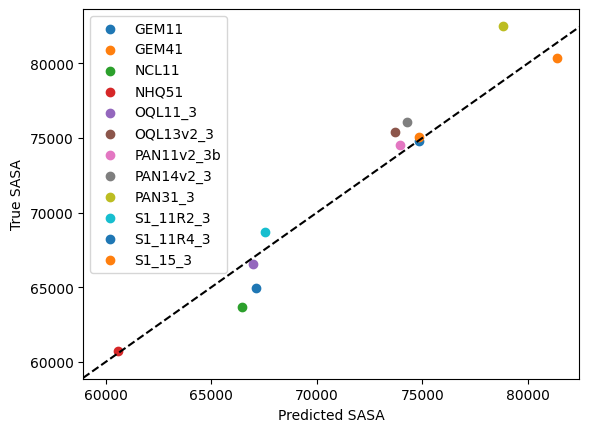

In [ ]:
plot_true_and_predicted_sasa(mbtr_model, sasa_model)